# Classify Stars in Colliding Galaxies

Using ~5000 labeled stars out of ~80,000 in each galaxy (170,000 stars total), make a model to predict and/or classify all the stars in the collection of the galaxy collision.

![KNN Classifier results for colliding galaxies](Assets/KNNPredictionResult.png "Classifying Stars in Colliding Galaxies")


As an optional assignment: 
- Find all neighboring pairs of points in two approaching galaxies.

Follow the creation of two synthetically created star locations in Euclidean coordinates. The galaxies are set to collide with each other. Techniques described are an approach to classifying which stars belong to which galaxy after the collision. We also later identify the coordinates of pairs of points that lie within a radius R of each other. Points already lying with radius R in either galaxy are ignored, and the focus is narrowed to points in one galaxy in close proximity to the points in the other galaxy.

We synthesize ~ 80,000 stars in each of two galaxies—a fictitious GFFA ("galaxy far, far away") and a fictitious "Xeno", which is the backdrop for Superman's Krypton. Combined, this is over 100,000 stars, for which we search for neighboring pairs on the order of a few light years apart.

Play the following video which plots and rotates the combined galaxies. It plots a 3D scatter plot of the nearly 200,000 stars in the two galaxies. It gradually reduces the opacity of each star to ultimately reveal the one or two or handfuls of stars that are within a given radius of each other as a result of the collision of the two galaxies. The center bulge in each galaxy is so dense that the red zone stars are not visible until we turn the opacity of the stars down significantly.


<video controls src="Videos/CollidingGalaxiesAnimation.mp4" />




# Learning Objectives:
 
1. Apply Multiple Classification Algorithms with GPU to classify stars belonging to each galaxy.
1. Apply Intel® Extension for Scikit-learn* patch and SYCL context to compute on available GPU resource.
1. **Optional**: Use KDtree, also known as k-d tree, to find all stars interacting within a given radius (say two light years) due to the collision of two galaxies.


## Library Dependencies:

 - **pip install pickle**
 - also requires these libraries if they are not already installed: **matplotlib, numpy, pandas, time, sklearn**
 
To synthesized the galaxy data uses a parametric equations described in the following paper [A New Formula Describing the Scaffold Structure of Spiral Galaxies](https://arxiv.org/ftp/arxiv/papers/0908/0908.0892.pdf) regarding the parametric equation of arm: :


$$ r \left( \phi \right) = \frac{A}{log(B \  \ tan(\frac{\phi}{2N}))  } $$

The synthesizer used here, generates an arbitrary number of arms, generates a 3D gauassian distribution of stars around a galactic center, then distributes a gausian distribiutoin  of stars along the length of each arm. In addition, it generates an arbitrary number of "globular clusters" of stars accoring to a 3D gaussian distribution sprinkled out randomly along the arm curves.

We also used rotation matrices  from this blog [3D Rotations and Euler angles in Python](https://www.meccanismocomplesso.org/en/3d-rotations-and-euler-angles-in-python/)


### Fictitious Galaxies: 

We create two fictitious galaxies: GFFA ("galaxy far, far away") and Xeno (The purported galaxy for Superman's planet Krypton). We intersect the galaxies and use various classification algorithms to identify the stars in each galaxy.

# k Nearest Neighbors

kNN classification follows the general workflow described in the oneAPI Giyhub repository [Classification Usage Model](https://oneapi-src.github.io/oneDAL/daal/usage/training-and-prediction/classification.html#classification-usage-model).

k-Nearest Neighbors (kNN) classification is a classification (or regression) algorithm. The model of the kNN classifier is based on feature vectors and class labels from the training data set. It uses distances between points as a key element for classifying similar points.

# Random Forest

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.


# Creation of Galaxies

In [1]:
import math as m
import numpy as np
import random
import math as m
import matplotlib.pyplot as plt
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
  
def Ry(theta):
    return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
def Rz(theta):
    return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

def ParametricPolar2Rectangular(r2, phi):
    x = r2*np.cos(phi) #+.08 * random.normal(loc=0, scale=.68, size=(NBlue))
    y = r2*np.sin(phi) #+.04 * random.normal(loc=0, scale=.34, size=(NBlue))
    z = np.zeros(len(x))
    return np.array([x,y,z]).T

def R(phi, A, B, N, Phase=0.0):
    return np.nan_to_num( A/np.log( B*np.tan(phi/(2.0*N))))

def createGalaxyArms(phi, arms = 6, A = 1.0, B = .69, N = 5, Radius = 4.0e5, 
                     bandMaxWidth = 80, GlobRadius = 3.0e4,GlobNumber = 2000, GlobZSquish = .1):
    rot = 360/arms
    band = []
    cumsum = list(np.cumsum(np.histogram(phi, bins = 10)[0]))
    percent = (np.histogram(phi)[0] / sum(np.histogram(phi, bins = 10)[0]))
    #print('cumsum ', cumsum)
    #print('percent ', percent)   
    L = len(percent)
    # each band indicates the width and number of stars to put into an arm at each band lavel
    # populate stars in a generic non locality specific way into each band
    for j in range(L):
        band.append(bandMaxWidth * (L-j)/100. * np.random.normal(loc=0, scale=1, size=( L-j,3)))
    for i in range (arms):
        # coompute location r, phi given this equation which is governed by paramater phi
        # A, B, N control the shape and length of an arm
        r2 = R(phi, A, B, N )
        # StatCenterCartesian eapnads our little galaxy to a rough radius say in light years
        StatCenterCartesian = Radius*ParametricPolar2Rectangular(r2, phi) 
        j = 0
        # loop thru all known star center/ centroids in a single arm, create a grouping of stars at each centroid 
        for k in range(len(phi)):
            # k ranges over the length of an arm
            # in each range of values of k, a different size and population of stars will be generated
            if k > cumsum[j]:
                j += 1
            Stars_onej = band[j].copy()
            # set z coordinate to zero for now
            Stars_onej[:,2] = 0
            # add the StatCenterCartesian to each star in the band by stacking the array vertically
            Stars_onej += StatCenterCartesian[k] # this needs work, this needs to be doen once per band not once per k
            if k == 0:
                Stars_oneArm = Stars_onej
            else:
                Stars_oneArm = np.vstack((Stars_oneArm,Stars_onej))
            # at this point a single galaxy arm has been populated
            # to get the other arms positions, we do a matrix rotation using Rz
            
        # add a few globular clusters randomly in each arm
        N_GlobularClusters = 4
        N_GlobularClusterStars = 100
        R_GlobularCluster = 300
        GlobularCLustersAtZero = R_GlobularCluster * np.random.normal(loc=0, scale=1, size=(N_GlobularClusterStars,3))
        GlobCOffset = np.random.uniform(low = -5*R_GlobularCluster,  high= 5*R_GlobularCluster, size=(N_GlobularClusters,3))

        phiGlobC = np.random.uniform(low= 0,  high= np.pi/2.0, size=(N_GlobularClusters,))
        r3 = R(phiGlobC, A, B, N )
        #print(ParametricPolar2Rectangular(r3, phiGlobC).shape, GlobCOffset.shape, GlobularCLustersAtZero.shape )
        RGlobC = Radius * ParametricPolar2Rectangular(r3, phiGlobC) + GlobCOffset
        GlobularCLustersAtR = []
        for gc in range(N_GlobularClusters):
            Stars_oneArm = np.vstack((np.array(Stars_oneArm), GlobularCLustersAtZero + RGlobC[gc]))
        Stars_eachArm = np.vstack((np.array(Stars_oneArm*Rz(i*rot*np.pi/180.)), RGlobC))

        
        #print(Stars_eachArm.shape)
        # keep rotations for StatCenterCartesian_eachArm as well
        StatCenterCartesian_eachArm = np.array(StatCenterCartesian*Rz(i*rot*np.pi/180.))
        # next we vertically stack all data for all arms into Stars_allArms
        if i == 0:
            Z_allArms = StatCenterCartesian_eachArm
            Stars_allArms = Stars_eachArm
        else:
            Z_allArms = np.vstack((Z_allArms,StatCenterCartesian_eachArm)) 
            Stars_allArms = np.vstack((Stars_allArms,Stars_eachArm)) 
        # next create a glob of stars at center fo galaxy
        CenterGlob = GlobRadius * np.random.normal(loc=0, scale=[1, 1, GlobZSquish], size=(GlobNumber,3))
        # Put ALL galaxy stars into Stars
        Stars = np.vstack((Stars_allArms , CenterGlob))
    return Stars_allArms, CenterGlob, Stars

def dist(p1, p2):
    diff = p1 - p2
    return np.sqrt(diff.dot(diff))

def distInd(tooClose, index1, index2):
    diff = tooClose[index1] - tooClose[index2]
    return np.sqrt(diff.dot(diff))

def unpack_sklearn_query_radii(Stars, neighbors, counts):
    tooClose = []
    for pair in neighbors[counts > 1]:
        tooClose.append(Stars[pair[0]])
        tooClose.append(Stars[pair[1]])
    return np.array(tooClose)

def write_dictionary(dictionary, fn):
    import pickle
    import os
    here = './'
    # Store data (serialize)
    with open(os.path.join(here,fn), 'wb') as handle:
        #pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(dictionary, handle)
    return

def read_dictionary(fn):
    import pickle
    # Load data (deserialize)
    with open(fn, 'rb') as handle:
        dictionary = pickle.load(handle)
    return dictionary

def add(arr, myset):
    for pt3D in arr:
        mylist = []
        for pt in pt3D:
            mylist.append(round(pt,0))
        if(tuple(mylist) not in myset):
            myset.add(tuple(mylist))
            
#write_dictionary(collision, 'collision.pkl')
#collision = read_dictionary('collision.pkl')
GalaxyFromFile = True

# Draw Randomly Generated stars for GFFA galaxy

In [2]:
%matplotlib inline
if GalaxyFromFile == False:
    phi = np.abs(np.random.normal(loc=0, scale=.8, size=(600,1)))
    phi =  phi[phi<np.pi/2.]
    Arms, CenterGlob, Stars = createGalaxyArms(phi, arms = 5, Radius = 4.0e4, bandMaxWidth = 1.0e4, GlobRadius = 4e3, GlobNumber = 60000)

    GFFA = dict()
    GFFA['Arms'] = Arms.copy()
    GFFA['CenterGlob'] = CenterGlob.copy()
    GFFA['Stars'] = Stars.copy()
    print("GFFA['Stars'][:,0]", GFFA['Stars'].shape)

    GFFA['CenterGlob'] = np.vstack((GFFA['CenterGlob'],np.array([101,100,0])))
    GFFA['Stars'] = np.vstack((GFFA['Stars'],np.array([101,100,0])))

    plt.style.use('dark_background')
    plt.scatter(GFFA['Stars'][:,0], GFFA['Stars'][:,1], c = 'cyan', s = .1, alpha = .2)


# Draw Generated Stars for GFFA in stored file

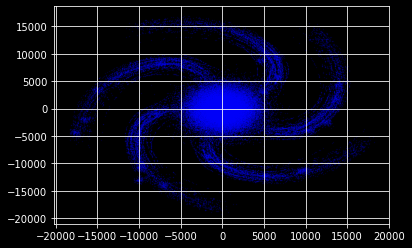

In [3]:
if GalaxyFromFile:
    GFFA = read_dictionary('GFFA.pkl')
    plt.style.use('dark_background')
    #plt.scatter(Arms[:,0], Arms[:,1], c='thistle', s = .1, alpha = 1)
    #plt.scatter(CenterGlob[:,0], CenterGlob[:,1], c = 'indigo', s = .1, alpha = .7)
    plt.grid()
    plt.scatter(GFFA['Stars'][:,0], GFFA['Stars'][:,1], c = 'blue', s = .1, alpha = .2)
    plt.style.use('dark_background')

# Draw Randomly Generated Stars for XenoSupermanGalaxy

In [4]:
if GalaxyFromFile ==  False:
    phi = np.abs(np.random.normal(loc=0, scale=.8, size=(600,1)))
    phi =  phi[phi<np.pi/2.]
    Arms, CenterGlob, Stars = createGalaxyArms(phi, arms = 7, Radius = 6.0e4, bandMaxWidth = 1e4, GlobRadius = 5e3, GlobNumber = 60000)
    XenoSupermanGalaxy = dict()
    GalacticTranslationalOffset = [500,-200,100]
    XenoSupermanGalaxy['Arms'] = (np.array(Arms * Rx(60)*Ry(45)) - GalacticTranslationalOffset).copy()
    XenoSupermanGalaxy['CenterGlob'] = (np.array(CenterGlob * Rx(60) * Ry(45)) - GalacticTranslationalOffset).copy()
    XenoSupermanGalaxy['Stars'] = (np.array(Stars * Rx(60) * Ry(45)) - GalacticTranslationalOffset).copy()

    XenoSupermanGalaxy['CenterGlob'] = np.vstack((XenoSupermanGalaxy['CenterGlob'],np.array([100,100,0])))
    XenoSupermanGalaxy['Stars'] = np.vstack((XenoSupermanGalaxy['Stars'],np.array([100,100,0])))

    print("XenoSupermanGalaxy['Stars'].shape", XenoSupermanGalaxy['Stars'].shape)

    plt.scatter(XenoSupermanGalaxy['Stars'][:,0], XenoSupermanGalaxy['Stars'][:,1], c = 'violet', s = .1, alpha = .2)
    plt.style.use('dark_background')

# Draw Stars for XenoSupermanGalaxy in stored file

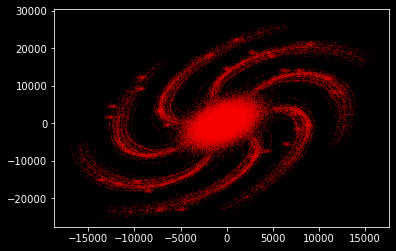

In [5]:
if GalaxyFromFile:
    XenoSupermanGalaxy = read_dictionary('XenoSupermanGalaxy.pkl')

    plt.scatter(XenoSupermanGalaxy['Stars'][:,0], XenoSupermanGalaxy['Stars'][:,1], c = 'r', s = .1, alpha = .2)
    plt.style.use('dark_background')

# Create Superset of GFFA and XenoSupermanGalaxy

To track all tooClose stars

In [6]:
collision = dict()
collision['Arms'] = np.vstack((GFFA['Arms'].copy(), XenoSupermanGalaxy['Arms'].copy()))
collision['CenterGlob'] = np.vstack((GFFA['CenterGlob'].copy(), XenoSupermanGalaxy['CenterGlob'].copy()))
collision['Stars'] = np.vstack((GFFA['Stars'].copy(), XenoSupermanGalaxy['Stars'].copy()))
collision['Stars'].shape

(171286, 3)

# On CPU for now, Train a kNN Classifier on a Small Subset of Stars From Each Galaxy

In [7]:
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

from sklearn import datasets
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from random import sample
from sklearn.neighbors import KDTree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# dataset is subset of stars from each galaxy
TrainingSize = min(len(GFFA['Stars']), len(XenoSupermanGalaxy['Stars'] ) ) 


# get the index of the stars to use from XenoSupermanGalaxy
XenoIndex = np.random.choice(len(XenoSupermanGalaxy['Stars']), TrainingSize, replace=False)
# get the index of the stars to use from GFFAIndex
GFFAIndex = np.random.choice(len(GFFA['Stars']), TrainingSize, replace=False)

# create a list with a labelforeahc item in the combined training set
# the first hald of the list indicates that class 0 will be for GFFA, 1 will be XenoSupermanGalaxy
y = [0]*TrainingSize + [1]*TrainingSize
# Stack the stars subset in same order as the labels, GFFA first, XenoSupermanGalaxy second
trainGalaxy = np.vstack((GFFA['Stars'][GFFAIndex], XenoSupermanGalaxy['Stars'][XenoIndex]))  

x_train, x_test, y_train, y_test = train_test_split(trainGalaxy, np.array(y), train_size=0.05)

# fit a k-nearest neighbor model to the data
K = 3
model = KNeighborsClassifier(n_neighbors = K)
model.fit(x_train, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


KNeighborsClassifier(n_neighbors=3)

In [8]:
 np.random.choice(len(XenoSupermanGalaxy['Stars']), TrainingSize, replace=False)

array([30880, 28944, 20485, ..., 37966, 36904, 47930])

# Use kNN Model to Classify Stars in Collision Dataset


In [9]:
# make predictions
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import dpctl
# assign the true labels for the collision data set, we know that collsions is stacked w GFFA first
y_true = [0]*GFFA['Stars'].shape[0] + [1]*XenoSupermanGalaxy['Stars'].shape[0]
# use the KNN model from before to predict all the stars contained in the combined collision dataset
# It is possible to specify to make the computations on GPU
for d in dpctl.get_devices():
    if d.is_gpu:
        device = dpctl.select_gpu_device()
    else:
        device = dpctl.select_cpu_device() 
        
print(device.device_type)
with dpctl.device_context(device): 
    model.fit(x_train, y_train.ravel())
    y_pred = model.predict(collision['Stars'])

print('Display results of KNN classification')
print('K',K)
print('Training size: ', TrainingSize)
print('GFFA results: predicted: {} Actual: {}'.format( y_pred[y_pred == 0].shape[0], GFFA['Stars'].shape[0]))
print('XenoSupermanGalaxy results: predicted: {} Actual: {}'.format( y_pred[y_pred == 0].shape[0], XenoSupermanGalaxy['Stars'].shape[0]))
print('Confusion Matrix: \n',confusion_matrix(y_true, y_pred))
print('recall: {:4.1f}'.format(100*recall_score(y_true, y_pred, average='binary')))
print('precision: {:4.1f}'.format(100*precision_score(y_true, y_pred, average='binary')))

GFFA_PredcitedIndex = np.where(y_pred == 0)[0] #get an index of GFFA predicted stars for plotting
Xeno_PredcitedIndex = np.where(y_pred == 1)[0] #get an index of GFFA predicted stars for plotting

device_type.cpu
Display results of KNN classification
K 3
Training size:  81486
GFFA results: predicted: 83039 Actual: 81486
XenoSupermanGalaxy results: predicted: 83039 Actual: 89800
Confusion Matrix: 
 [[77636  3850]
 [ 5403 84397]]
recall: 94.0
precision: 95.6


# Plot Results of KNN Classification

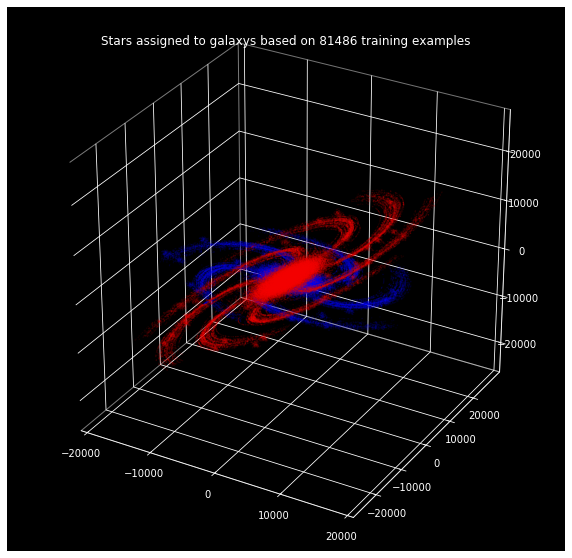

In [10]:
# Plot galaxy matplotlib
%matplotlib inline
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
# Creating figure
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")

ax.set_xticks([-20000, -10000, 0, 10000, 20000])
ax.set_yticks([-20000, -10000, 0, 10000, 20000])
ax.set_zticks([-20000, -10000, 0, 10000, 20000])

# ax.axes.set_xlim3d(left=0.2, right=9.8) 
# ax.axes.set_ylim3d(bottom=0.2, top=9.8) 
#ax.axes.set_zlim3d(bottom=-5000, top=5000) 

GFFA_PredcitedIndex = np.where(y_pred == 0)[0] #get an index of GFFA predicted stars for plotting
Xeno_PredcitedIndex = np.where(y_pred == 1)[0] #get an index of GFFA predicted stars for plotting

# Creating plot
ax.scatter(collision['Stars'][GFFA_PredcitedIndex,0], 
           collision['Stars'][GFFA_PredcitedIndex,1],
           collision['Stars'][GFFA_PredcitedIndex,2], color = "blue", s = .2, alpha = .1)

ax.scatter(collision['Stars'][Xeno_PredcitedIndex,0], 
           collision['Stars'][Xeno_PredcitedIndex,1],
           collision['Stars'][Xeno_PredcitedIndex,2], color = "red", s = .2, alpha = .1)


plt.title("Stars assigned to galaxys based on {} training examples".format(TrainingSize))
plt.style.use('dark_background')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

# show plot
plt.show()

# Plot result of classification

This time a static image of a previous run of the algorithm showing one galaxy edge on

![galaxyRed_BlueEdge.png](Assets/galaxyRed_BlueEdge.png)


# Try Multiple Classification Algorithms 

On **GPU** if available, otherwise **CPU**

In [11]:
import time
import dpctl
myModels = {'KNeighborsClassifier':KNeighborsClassifier(n_neighbors = K) , 
            'RandomForestClassifier': RandomForestClassifier(n_jobs=2, random_state=0) #,
            #'SVC':SVC(gamma='auto'), 
            #'NuSVC':NuSVC(gamma='auto')
           }

for d in dpctl.get_devices():
    if d.is_gpu:
        device = dpctl.select_gpu_device()
    else:
        device = dpctl.select_cpu_device() 
        
for name, modelFunc in myModels.items():
    start = time.time()
    print(device.device_type)
    with dpctl.device_context(device): 
        model = make_pipeline(StandardScaler(), modelFunc)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)  
           
    print('Display results of {} classification'.format(name))
    print('K: ',K)
    print('Training size: ', TrainingSize)
    print('Confusion Matrix: \n',confusion_matrix(y_test, y_pred))
    print('recall: {:4.1f}'.format(100*recall_score(y_test, y_pred, average='binary')))
    print('precision: {:4.1f}'.format(100*precision_score(y_test, y_pred, average='binary')))
    print('roc_auc_score: {:4.1f} '.format(100*roc_auc_score(y_test, y_pred)))
    GFFA_PredcitedIndex = np.where(y_test == 0) #get an index of GFFA predicted stars for plotting
    Xeno_PredcitedIndex = np.where(y_test == 1) #get an index of GFFA predicted stars for plotting


device_type.cpu
Display results of KNeighborsClassifier classification
K:  3
Training size:  81486
Confusion Matrix: 
 [[73704  3748]
 [ 4664 72708]]
recall: 94.0
precision: 95.1
roc_auc_score: 94.6 
device_type.cpu
Display results of RandomForestClassifier classification
K:  3
Training size:  81486
Confusion Matrix: 
 [[75161  2291]
 [ 5113 72259]]
recall: 93.4
precision: 96.9
roc_auc_score: 95.2 


# Sweep Through Training Size Needed

Camp on a single model and sweep TrainingSize as a variable. 

We try muliple models and multiple training size values to determine which comboination of models and training size yield optimimum Receiver Operator Characteristic (ROC) scores

In [13]:
import time
myModels = {'KNeighborsClassifier':KNeighborsClassifier(n_neighbors = K) , 
            'RandomForestClassifier': RandomForestClassifier(n_jobs=2, random_state=0), 
            #'SVC':SVC(gamma='auto'), 
           }
TrainingSize = [.001, .01,  .1, .2,  .8]
bestScore = {}
hi = 0
for tsz in TrainingSize:
    x_train, x_test, y_train, y_test = train_test_split( \
                trainGalaxy, np.array(y), train_size=tsz)
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    for name, modelFunc in myModels.items():       
        start = time.time()
        model = modelFunc
        print(device.device_type)
        with dpctl.device_context(device):
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)
                
        print('Display results of {} classification'.format(name))
        print('  K: ',K)
        print('  Training size: ', tsz)
        print('  y_train.shape: ',y_train.shape)
        roc = roc_auc_score(y_test, y_pred)
        print('  roc_auc_score: {:4.1f}'.format(100*roc))
        print('  Time: {:5.1f} sec\n'.format( time.time() - start))
        if roc > hi:
            hi = roc
            bestScore = {'name': name,
                    'roc':roc, 
                    'trainingSize':tsz, 
                    'confusionMatrix': confusion_matrix(y_test, y_pred), 
                    'precision': 100*precision_score(y_test, y_pred, average='binary'),
                    'recall': recall_score(y_test, y_pred, average='binary') }
print('bestScore: name', bestScore['name'])
print('bestScore: confusion Matrix', bestScore['confusionMatrix'])
print('bestScore: precision', bestScore['precision'])
print('bestScore: recall', bestScore['recall'])
print('bestScore: roc', bestScore['roc'])

device_type.cpu
Display results of KNeighborsClassifier classification
  K:  3
  Training size:  0.001
  y_train.shape:  (162,)
  roc_auc_score: 89.2
  Time:   0.0 sec

device_type.cpu
Display results of RandomForestClassifier classification
  K:  3
  Training size:  0.001
  y_train.shape:  (162,)
  roc_auc_score: 93.0
  Time:   0.1 sec

device_type.cpu
Display results of KNeighborsClassifier classification
  K:  3
  Training size:  0.01
  y_train.shape:  (1629,)
  roc_auc_score: 93.3
  Time:   0.0 sec

device_type.cpu
Display results of RandomForestClassifier classification
  K:  3
  Training size:  0.01
  y_train.shape:  (1629,)
  roc_auc_score: 94.3
  Time:   0.1 sec

device_type.cpu
Display results of KNeighborsClassifier classification
  K:  3
  Training size:  0.1
  y_train.shape:  (16297,)
  roc_auc_score: 94.7
  Time:   0.1 sec

device_type.cpu
Display results of RandomForestClassifier classification
  K:  3
  Training size:  0.1
  y_train.shape:  (16297,)
  roc_auc_score: 95.4

In [ ]:
confusion_matrix(y_test, y_pred)

# Optional: Use KDtree to Find All Points Within Radius R

This is not directly optimized by Intel at this point but is used under the hood by Intel's kNN which is optimized.

Because we are dealing with a fairly large number of points (more than a few thousand) let's explore the inherent data structure used by the KNN under the hood - k-d tree to see how quickly we can find pairs of points within radius R of each other.

This mechanism is very efficient and KDtree algorithms have this estimate of computation and space complexity.
[Wikipedia k-d tree](https://en.wikipedia.org/wiki/K-d_tree):

![Complexity](Assets/KDTREE_Complexity.png)

Following this, we find the all nearly colliding stars (here we will say stars within three light years from each other). This could answer the question: **Did these galaxies result in more "tooClose" encounters after the collision?**



In [ ]:
%%time
Radius = 3

tree = KDTree(GFFA['Stars'], leaf_size = 42)              
neighbors = tree.query_radius(GFFA['Stars'],  Radius) 
counts = tree.query_radius(GFFA['Stars'],  Radius, count_only = 1)
GFFA['tooClose']  = unpack_sklearn_query_radii(GFFA['Stars'], neighbors, counts)

tree = KDTree(XenoSupermanGalaxy['Stars'], leaf_size = 42)              
neighbors = tree.query_radius(XenoSupermanGalaxy['Stars'],  Radius) 
counts = tree.query_radius(XenoSupermanGalaxy['Stars'],  Radius, count_only = 1)
XenoSupermanGalaxy['tooClose']  = unpack_sklearn_query_radii(XenoSupermanGalaxy['Stars'], neighbors, counts)


collision = dict()  
collision['Arms'] = np.vstack((GFFA['Arms'].copy(), XenoSupermanGalaxy['Arms'].copy()))
collision['CenterGlob'] = np.vstack((GFFA['CenterGlob'].copy(), XenoSupermanGalaxy['CenterGlob'].copy()))
collision['Stars'] = np.vstack((GFFA['Stars'].copy(), XenoSupermanGalaxy['Stars'].copy())).copy()
tree = KDTree(collision['Stars'], leaf_size = 42)  

#kdtree  tree.query_radius

neighbors = tree.query_radius(collision['Stars'],  Radius) 
counts = tree.query_radius(collision['Stars'],  Radius, count_only = 1)
collision['tooClose']  = unpack_sklearn_query_radii(collision['Stars'], neighbors, counts)

print("GFFA['Stars'].shape ", GFFA['Stars'].shape)
print("XenoSupermanGalaxy['Stars'].shape ", XenoSupermanGalaxy['Stars'].shape)
print("collision['Stars'].shape ", collision['Stars'].shape)

print("\nGFFA['tooClose'].shape ", GFFA['tooClose'].shape)
print("XenoSupermanGalaxy['tooClose'].shape ", XenoSupermanGalaxy['tooClose'].shape)
print("collision['tooClose'].shape ", collision['tooClose'].shape)

# Find Glactic Collision Near Misses

In [ ]:
          
GFFA['tooClose']
GFFAset = set()           
add(GFFA['tooClose'], GFFAset)
print('GFFAset ', len(GFFAset))
XenoSupermanGalaxy['tooClose']
XenoSupermanGalaxyset = set()           
add(XenoSupermanGalaxy['tooClose'], XenoSupermanGalaxyset)
print('XenoSupermanGalaxyset ', len(XenoSupermanGalaxyset))

collision['tooClose']
collisionset = set()           
add(collision['tooClose'], collisionset)
print('collisionset ', len(collisionset))

GFFAStarsSet = set()           
add(GFFA['Stars'], GFFAStarsSet)

XenoSupermanGalaxyStarsSet = set()           
add(XenoSupermanGalaxy['Stars'], XenoSupermanGalaxyStarsSet)

GalacticCollision = collisionset - XenoSupermanGalaxyset - GFFAset
print( 'Galactic Collisions list of star locations where distance less than {} light years : {}'.format(Radius, GalacticCollision))

# With the Aid of Python Sets We Find the Interacting Points

Essentially, for each galaxy individually, we find all existing stars within three lights years within a single glaxay. Next find all stars within three light years in the combined galaxy. To find all stars in one galaxy that are within three light years of a star in a different galaxy perform the set difference as follows:

**GalacticCollision = collisionset - XenoSupermanGalaxyset - GFFAset**

The number of stars in near-collision state as a result of colliding galaxies (< 3 light years) consists of all stars three light years apart after we account for stars within each galaxy separelty that were already within three light years separation BEFORE collision.

What remains are the stars in Xeno that are locally close to stars in GFFA. 

# Plot Star Positions in Red

For those stars from one galaxy that are within three light years of a star in another galaxy

In [ ]:
# # Plot galaxy matplotlib
%matplotlib inline
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
# Creating figure
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")

ax.set_xticks([-20000, -10000, 0, 10000, 20000])
ax.set_yticks([-20000, -10000, 0, 10000, 20000])
ax.set_zticks([-20000, -10000, 0, 10000, 20000])

# ax.axes.set_xlim3d(left=0.2, right=9.8) 
# ax.axes.set_ylim3d(bottom=0.2, top=9.8) 
#ax.axes.set_zlim3d(bottom=-5000, top=5000) 

# Creating plot
GalacticCollisionsNP = np.array(list(GalacticCollision))

ax.scatter3D(GFFA['Stars'][::5,0], 
             GFFA['Stars'][::5,1], 
             GFFA['Stars'][::5,2], color = "blue", s = .2, alpha = 0)

ax.scatter3D(XenoSupermanGalaxy['Stars'][::5,0], 
             XenoSupermanGalaxy['Stars'][::5,1], 
             XenoSupermanGalaxy['Stars'][::5,2], color = "g", s = .2, alpha = 0 )

ax.scatter3D(GalacticCollisionsNP[:,0], 
             GalacticCollisionsNP[:,1], 
             GalacticCollisionsNP[:,2], color = "r", s = 50, alpha = 1)

plt.title("Stars within {} light years".format(Radius))
plt.style.use('dark_background')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

# show plot
plt.show()

# Plot result of classification

This time a static image of a previous run of the algorithm showing one galaxy edge on

![galaxyRed_BlueEdge.png](Assets/galaxyRed_BlueEdge.png)

# Notices & Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure.
Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
*Other names and brands may be claimed as the property of others.
